# GeoFNO SpectralConv Test

In [3]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
from timeit import default_timer
from scipy.io import loadmat

torch.set_printoptions(precision=16)


In [4]:
def compute_Fourier_modes(ndim, nks, Ls):
    # 2d 
    if ndim == 1:
        nx, Lx = nks[0], Ls[0]
        nk = nx
        k_pairs    = np.zeros((nk, ndim))
        k_pair_mag = np.zeros(nk)
        i = 0
        for kx in range(1, nx + 1):
            k_pairs[i, :] = 2*np.pi/Lx*kx 
            k_pair_mag[i] = np.linalg.norm(k_pairs[i, :])
            i += 1

    elif ndim == 2:
        nx, ny = nks
        Lx, Ly = Ls
        nk = 2*nx*ny + nx + ny
        k_pairs    = np.zeros((nk, ndim))
        k_pair_mag = np.zeros(nk)
        i = 0
        for kx in range(-nx, nx + 1):
            for ky in range(0, ny + 1):
                if (ky==0 and kx<=0): 
                    continue

                k_pairs[i, :] = 2*np.pi/Lx*kx, 2*np.pi/Ly*ky
                k_pair_mag[i] = np.linalg.norm(k_pairs[i, :])
                i += 1
        

    k_pairs = k_pairs[np.argsort(k_pair_mag), :]
    return k_pairs

def compute_Fourier_bases(grid, modes, mask):
    #grid : batchsize, ndim, nx
    #modes: nk, ndim
    #mask : batchsize, 1, nx
    temp  = torch.einsum("bdx,kd->bkx", grid, modes) 
    #temp: batchsize, nx, nk
    bases_c = torch.cos(temp) * mask
    bases_s = torch.sin(temp) * mask
    bases_0 = mask
    return bases_c, bases_s, bases_0

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply, at most floor(N/2) + 1
        nmode, ndim = modes.shape
        self.modes = modes

        self.weights_c = torch.ones(in_channels, out_channels, nmode)
        self.weights_s = torch.zeros(in_channels, out_channels, nmode)
        self.weights_0 = torch.ones(in_channels, out_channels, 1)
        #!!!!
        self.weights_c[:,:,-1] /=2.0
        
    def forward(self, x, wbases_c, wbases_s, wbases_0, bases_c, bases_s, bases_0):
        size = x.shape[-1]

        x_c_hat =  torch.einsum("bix,bkx->bik", x, wbases_c)
        x_s_hat = -torch.einsum("bix,bkx->bik", x, wbases_s)
        x_0_hat =  torch.einsum("bix,bkx->bik", x, wbases_0)
        
        weights_c, weights_s, weights_0 = self.weights_c/(size), self.weights_s/(size), self.weights_0/(size)

        f_c_hat = torch.einsum("bik,iok->bok", x_c_hat, weights_c) - torch.einsum("bik,iok->bok", x_s_hat, weights_s)
        f_s_hat = torch.einsum("bik,iok->bok", x_s_hat, weights_c) + torch.einsum("bik,iok->bok", x_c_hat, weights_s)
        f_0_hat = torch.einsum("bik,iok->bok", x_0_hat, weights_0) 

        x = torch.einsum("bok,bkx->box", f_0_hat, bases_0)  + 2*torch.einsum("bok,bkx->box", f_c_hat, bases_c) -  2*torch.einsum("bok,bkx->box", f_s_hat, bases_s) 
        
        return x
    



norm(x - x_conv) =  3.672254609260741e-14


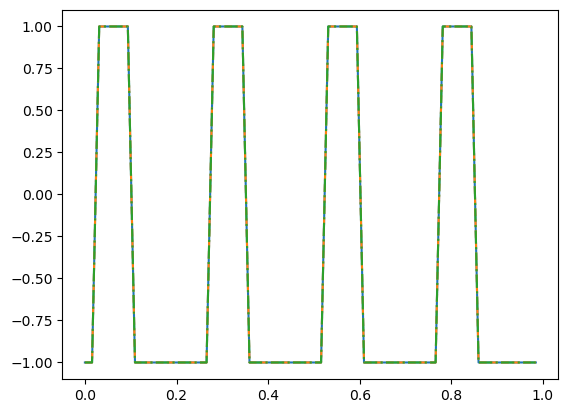

In [5]:
L = 1 
Np_ref = 64
grid_1d = torch.linspace(0, L, Np_ref+1,dtype=torch.double)[np.newaxis, np.newaxis, 0:-1]
weights = torch.ones(1,1,Np_ref,dtype=torch.double)/Np_ref
mask = torch.ones(1,1,Np_ref,dtype=torch.double)
x = np.sin(2*np.pi*grid_1d*4)
x = torch.where(x > 0.5, torch.tensor(1.0, dtype=torch.double), torch.tensor(-1.0, dtype=torch.double))

modes = torch.tensor(compute_Fourier_modes(1, [Np_ref//2], [L]))
speconv = SpectralConv2d(1,1,modes)

size = grid_1d.shape[-1]
bases_c, bases_s, bases_0 = compute_Fourier_bases(grid_1d, modes, mask)
wbases_c, wbases_s, wbases_0 = bases_c*(weights*size), bases_s*(weights*size), bases_0*(weights*size)
     
x_conv = speconv(x, wbases_c, wbases_s, wbases_0, bases_c, bases_s, bases_0)


x_ft = torch.fft.rfftn(x, dim=[2])
x_ift = torch.fft.irfftn(x_ft, dim=[2])

print("norm(x - x_conv) = ", np.linalg.norm(x - x_conv))

plt.plot(grid_1d[0,0,:], x[0,0,:])
plt.plot(grid_1d[0,0,:], x_conv[0,0,:], "--")
plt.plot(grid_1d[0,0,:], x_ift[0,0,:], "-.")


norm(x - x_conv) =  3.052709573560087e-14


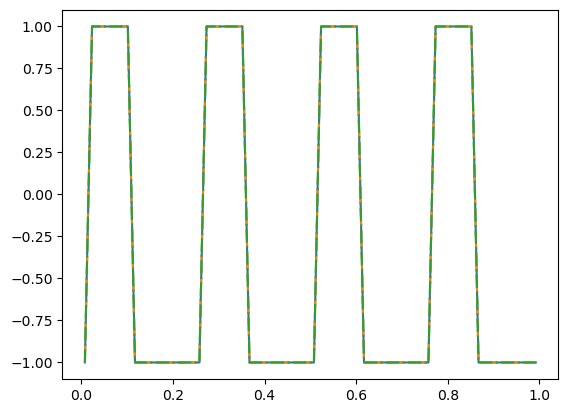

In [6]:
L = 1 
Np_ref = 64
dx = L/Np_ref
grid_1d = torch.linspace(dx/2, L-dx/2, Np_ref,dtype=torch.double)[np.newaxis, np.newaxis, :]
weights = torch.ones(1,1,Np_ref,dtype=torch.double)/Np_ref
mask = torch.ones(1,1,Np_ref,dtype=torch.double)
x = np.sin(2*np.pi*grid_1d*4)
x = torch.where(x > 0.5, torch.tensor(1.0, dtype=torch.double), torch.tensor(-1.0, dtype=torch.double))

modes = torch.tensor(compute_Fourier_modes(1, [Np_ref//2], [L]))
speconv = SpectralConv2d(1,1,modes)

size = grid_1d.shape[-1]
bases_c, bases_s, bases_0 = compute_Fourier_bases(grid_1d, modes, mask)
wbases_c, wbases_s, wbases_0 = bases_c*(weights*size), bases_s*(weights*size), bases_0*(weights*size)
     
x_conv = speconv(x, wbases_c, wbases_s, wbases_0, bases_c, bases_s, bases_0)


x_ft = torch.fft.rfftn(x, dim=[2])
x_ift = torch.fft.irfftn(x_ft, dim=[2])

print("norm(x - x_conv) = ", np.linalg.norm(x - x_conv))

plt.plot(grid_1d[0,0,:], x[0,0,:])
plt.plot(grid_1d[0,0,:], x_conv[0,0,:], "--")
plt.plot(grid_1d[0,0,:], x_ift[0,0,:], "-.")


# Load data

In [3]:
data_path = "../data/Darcy_2d/piececonst_r421_N1024_smooth1"
data = loadmat(data_path)

input date size:  (1024, 421, 421) output data size:  (1024, 421, 421)


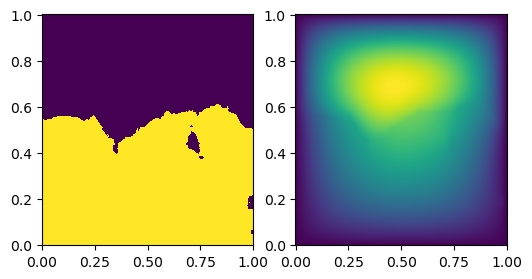

In [4]:
data_in = data["coeff"]
data_out = data["sol"]
print("input date size: ", data_in.shape, "output data size: ", data_out.shape)

L = 1 
Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)

grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].pcolormesh(grid_x, grid_y, data_in[0,:,:])
axs[1].pcolormesh(grid_x, grid_y, data_out[0,:,:])

In [11]:
# Here is a test, be careful, the torch will generally use float32. 
# To get accurate error estimate, use float64
downsample_ratio = 4
n_train = 2**10
x_train = torch.from_numpy(np.stack((data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio], 
                           np.tile(grid_x[0::downsample_ratio,0::downsample_ratio], (n_train,1,1)), 
                           np.tile(grid_y[0::downsample_ratio,0::downsample_ratio], (n_train,1,1))), axis=-1))

batchsize = 16
x = x_train[0:batchsize]
print(x.shape)
# batch, channel, x, y
x = x.permute(0, 3, 1, 2)
x_ft = torch.fft.rfftn(x, dim=[2,3])

x_ift = torch.fft.irfftn(x_ft, dim=[2,3])
print("Error between x and x_ift is ", torch.norm(x - x_ift))


torch.Size([16, 106, 106, 3])
Error between x and x_ift is  tensor(1.1347225397267032e-12, dtype=torch.float64)


Error between x and x_ift is  tensor(1.3465297236977153e-13, dtype=torch.float64)
tensor(146.0071268284307280-54.0852409798341398j, dtype=torch.complex128) tensor(146.0071268284307280+54.0852409798341398j, dtype=torch.complex128)
torch.Size([16, 3, 22, 12])
Error between x and x_ift is  tensor(8.3446953249315109e-13, dtype=torch.float64)


In [6]:
x_ift = torch.fft.irfftn(x_ft, dim=[2,3])
print("Error between x and x_ift is ", torch.norm(x - x_ift))

modes = 6
#  Truncate to the first m modes
x_ft_trunc = torch.zeros(n_b, n_c, n_x, n_k+1, dtype=torch.complex128)
x_ft_trunc[:, :,  :modes, :modes] = x_ft[:, :,  :modes, :modes]
x_ft_trunc[:, :, -modes+1:, :modes] = x_ft[:, :, -modes+1:, :modes]

x_ift_trunc = torch.fft.irfftn(x_ft_trunc, dim=[2,3])

# Implementation 1
Kr_x = torch.tensor(list(range(0, n_k)) + [-n_k] + list(range(-n_k+1, 0)), dtype=torch.float64)
Kr_y = torch.tensor(list(range(0, n_k)) + [-n_k], dtype=torch.float64)
bases = torch.einsum('xk,yl->xykl',
                     torch.exp( torch.outer(torch.linspace(0, n_x-1, n_x, dtype=torch.float64), 2*np.pi/n_x * 1.0j * Kr_x) ),
                     torch.exp( torch.outer(torch.linspace(0, n_y-1, n_y, dtype=torch.float64), 2*np.pi/n_y * 1.0j * Kr_y) )  
                    )
bases[:,:,:,1:-1] *= 2.0
x_ift2 = torch.real(torch.einsum('bckl,xykl->bcxy', x_ft_trunc, bases))/(n_x*n_y)
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))

# Low Rank Implementation
Kr_x = torch.tensor(list(range(0, modes)) + list(range(-modes+1, 0)), dtype=torch.float64)
Kr_y = torch.tensor(list(range(0, modes)), dtype=torch.float64)
Kr = torch.tensor(list(range(0, modes)), dtype=torch.float64)
bases = torch.einsum('xk,yl->xykl',
                     torch.exp( torch.outer(torch.linspace(0, n_x-1, n_x, dtype=torch.float64), 2*np.pi/n_x * 1.0j * Kr_x) ),
                     torch.exp( torch.outer(torch.linspace(0, n_y-1, n_y, dtype=torch.float64), 2*np.pi/n_y * 1.0j * Kr_y) )  
                    )
bases[:,:,:,1:] *= 2.0
x_ift2 = torch.real(torch.einsum('bckl,xykl->bcxy', x_ft_trunc[:, :, list(range(0, modes)) + list(range(-modes+1, 0)), :modes], bases))/(n_x*n_y)
print("Error between x and x_ift2 is ", torch.norm(x_ift_trunc - x_ift2))


Error between x and x_ift is  tensor(1.3465297236977153e-13, dtype=torch.float64)
Error between x and x_ift2 is  tensor(3.5653540552682406e-13, dtype=torch.float64)
Error between x and x_ift2 is  tensor(3.5653540552682406e-13, dtype=torch.float64)


# Spectral Transform

We compute the spectral transform for the last dimension of x. 
We first define $n_k$ orthonal bases $\{ \phi_k \}_{k = 0}^{n_k-1}$


Then the spectral transform and inverse spectral transform give the relation between 
$\{\hat{f}[k]: k \in K \}$ and $\{f(x_j) : 0 \leq j \leq n_x\}$

\begin{align*}
   f(x) &= \sum_{k=0}^{n_k-1}  \hat{f}[k]  \phi_k(x) 
   \\ 
   f(x_j) &= \sum_{k_x=0}^{n_k-1}  \hat{f}[k]  \phi_k(x_j)
   \\ 
   \hat{f}[k] &= \int  f(x)  \phi_k(x) dx  \\
                &= \sum_{j = 0}^{n_x}  f(x_j)  \phi_k(x_j) \Delta x_j
\end{align*}
Here $\phi_k(x)$ are orthogonal bases with $$\int \phi_i(x) \overline{\phi_k(x)} dx = \delta_{ik},$$ and at the discrete level
$$\sum_{j = 0}^{n_x} \phi_i(x_j) \overline{\phi_j(x_j)} \Delta x_j = \delta_{ik}$$



We set bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j)  & \phi_1(x_j)  &  \cdots &  \phi_{n_k-1}(x_j)  
\end{bmatrix}
\end{equation}
and weighted bases 
\begin{equation}
B = 
\begin{bmatrix}
\phi_0(x_j) \Delta x_j  & \phi_1(x_j) \Delta x_j &  \cdots &  \phi_{n_k-1}(x_j) \Delta x_j
\end{bmatrix}
\end{equation}

To recover 2D Fourier Transform, we set 
\begin{align*}
\phi_k(x) = \begin{cases}
\frac{a_{k}}{\sqrt{L_xL_y}}\sin(\frac{2\pi k_x x}{L_x} + \frac{2\pi k_y y}{L_y}) & k_y > 0 \cup  k_y=0 \, k_x \geq 0\\ 
\frac{a_{k}}{\sqrt{L_xL_y}}\cos(\frac{2\pi k_x x}{L_x} + \frac{2\pi k_y y}{L_y}) & 
\end{cases}
\end{align*}
with $a_{0,0} = 1$ and $a_{k} = \sqrt{2}$.
